# Introduction and Business Problem

For my Capstone project I will be comparing the different neighborhoods of the island of Oahu, Hawaii. I will 

*Can FourSquare data help incoming Oahu residents decide where on the island they would like to live?*

Thousands of people move to Oahu each year from the U.S. mainland and from abroad (http://dbedt.hawaii.gov/blog/19-40/). I myself moved to Oahu from the mainland six years ago. When apartment or house hunting, I think many people are presented with multiple options regarding which part of the island in which they would like to reside. Some incoming residents may even intend on opening a business on Oahu. Others move to Hawaii with their families, and are interested in neighborhood schools and crime rates. I would like to provide useful insight for incoming Oahu residents for deciding between different neighborhoods on the island.

I will utilize FourSquare data to analyze differences in the types and frequencies of businesses in each neighborhood. And when possible, analyze relationships between neighborhood crime and school performance. 

In addition to general analysis of the island, two specific examples will be considered:
* Mary is moving to Oahu and is considering opening either a bakery or an Italian restaraunt. Are there neighborhoods that favor one over the other?
* John is moving to Oahu with his family. He would like a neighborhood with nearby parks, but also low crime and good high schools. 


# Data

Foursquare data will be obtained through the use of a Foursquare Developer Account and the Foursquare API. I'll use the Oahu neighborhoods and postal codes found at https://www.kimicorrea.com/oahu-zip-codes/. 

For data on Oahu public schools, I will utilize the Strive HI Performance System results for 2017-2018 school year. This data was releasted by the Hawaii State Department of Education and is available for download as an Excel sheet at http://www.hawaiipublicschools.org/VisionForSuccess/AdvancingEducation/StriveHIPerformanceSystem/Pages/2017-18-results.aspx
To simplify this analysis, I will generate a combined math, language, and science score for public high schools only.

For Oahu crime data, I will utilize the Honolulu Police Department's 2018 Annual Report (http://www.honolulupd.org/downloads/HPD2018annualreport.pdf).

To join the different data sets, I will have to retrieve the postal code for each Oahu school and determine in which crime district each neighborhood resides (as the Oahu crime data is organized into eight separate districts). 

I plan on using a k-means cluster algorithm to cluster the different zip codes according to the most frequent types of business found in a radius around those zip codes. I will also look into the feasability of including the crime and school data in the cluster algorithm. Lastly, I will use NumPy to look into possible correlation between crime and school data. 

### Foursquare Data


In [1]:
# The code was removed by Watson Studio for sharing.

,Neighborhood,Zip Code
0,Aiea,96701
1,Ewa Beach,96706
2,Kapolei,96707
3,Kapolei,96709
4,Haleiwa,96712


In [2]:
#Import necessary libraries
import requests # library to handle requests
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                       

In [3]:
# The code was removed by Watson Studio for sharing.

In [4]:
#Install pgeocode to lookup lat/lon with zip code
!pip install pgeocode
import pgeocode


In [5]:
#First we'll state Honolulu's location for use in map creation later on
honolulu_latitude = 21.3069
honolulu_longitude = -157.8583

#Create an empty dataframe for a lat/lon dtaframe
# define the dataframe columns
column_names = ['Neighborhood','Zip Code', 'Latitude', 'Longitude'] 
# instantiate the dataframe
df_latlon = pd.DataFrame(columns=column_names)
nomi = pgeocode.Nominatim('us')
#Use a for loop to retrieve latitude and longitude for each postal code in df_zip
for index, row in df_zip.iterrows():
    neighborhood=row['Neighborhood']
    zip_code=row['Zip Code']
    location=nomi.query_postal_code(zip_code)
    neighborhood_lat=location.latitude
    neighborhood_lon=location.longitude
    df_latlon = df_latlon.append({'Neighborhood': neighborhood,
                                          'Zip Code': zip_code,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
#Correct Lat/Lon for Wake Island neighborhood, zip code 96898. Should be 21.3231° N, 157.8912 W
#Correct Lat/Lon for MCBH Kanheohe Bay. Should be 21.4521° N, 157.7699 W
#Correct Lat/Lon for Pearl Harbo. Should be 21.3485° N, 157.9583° W
#Correct Lat/Lon for Tripler. Should be 21.3558° N, 157.8941° W
#Correct Lat/Lon for Hickam. Should be 21.3316° N, 157.9375° W
#Correct Lat/Lon for Camp Smith. 21.3872° N, 157.9038° W
df_latlon.loc[65,'Latitude']=21.3231
df_latlon.loc[65,'Longitude']=-157.8912
df_latlon.loc[64,'Latitude']=21.4521
df_latlon.loc[64,'Longitude']=-157.7699
df_latlon.loc[66,'Latitude']=21.3485
df_latlon.loc[66,'Longitude']=-157.9583
df_latlon.loc[61,'Latitude']=21.3558
df_latlon.loc[61,'Longitude']=-157.8941
df_latlon.loc[57,'Latitude']=21.3316
df_latlon.loc[57,'Longitude']=-157.9375
df_latlon.loc[63,'Latitude']=21.3872
df_latlon.loc[63,'Longitude']=-157.9038

df_latlon.head()


,Neighborhood,Zip Code,Latitude,Longitude
0,Aiea,96701,21.3908,-157.9332
1,Ewa Beach,96706,21.3274,-158.0103
2,Kapolei,96707,21.3453,-158.0870
3,Kapolei,96709,21.3233,-158.0058
4,Haleiwa,96712,21.6312,-158.0693


In [6]:
#Remove redundant zip codes (with identical lat/lon coordinates)
index_names=df_latlon[ ((df_latlon['Zip Code'] == 96811) | (df_latlon['Zip Code'] == 96848)) | 
                                      ((df_latlon['Zip Code'] >= 96803) & (df_latlon['Zip Code'] <= 96810))].index
df_latlon2=df_latlon.drop(index_names).reset_index(drop='True')

In [64]:
#Create a function to retrieve nearby venues for each of the neighborhoods in the dataframe.
LIMIT=100#<-Limit number of requests
def getNearbyVenues(names, zipcode, latitudes, longitudes, radius=1000): #Originally tried a radius of 500...
    venues_list=[]
    for name, zc, lat, lng in zip(names, zipcode, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            zc,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Zip Code',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [65]:
#Run Function for each neighbourhood
oahu_venues = getNearbyVenues(names=df_latlon2['Neighborhood'],
                                    zipcode=df_latlon2['Zip Code'],
                                   latitudes=df_latlon2['Latitude'],
                                   longitudes=df_latlon2['Longitude'])
oahu_venues.head()

Aiea
Ewa Beach
Kapolei
Kapolei
Haleiwa
Hauula
Kaaawa
Kahuku
Kailua
Kaneohe
Kunia
Laie
Pearl City
Wahiawa
Mililani
Waialua
Waianae
Waimanalo
Waipahu
Honolulu
Honolulu
Honolulu
Honolulu
Honolulu
Waikiki
Waialae / Kahala
Kapalama
Kapalama
Honolulu
Waialae / Kahala
Makiki
Honolulu
Honolulu
Honolulu
Makiki
Honolulu
Honolulu
Honolulu
Honolulu
Honolulu
Honolulu
Honolulu
Honolulu
Honolulu
Honolulu
Honolulu
Honolulu
Hickam AFB
Wheeler Army Airfield
Schofield Barracks
Fort Shafter
Tripler Army Medical Center
Pearl Harbor
Camp H M Smith
M C B H Kaneohe Bay
Wake Island
Pearl Harbor


,Neighborhood,Zip Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aiea,96701,21.3908,-157.9332,Pearl Country Club,21.392433,-157.935925,Golf Course
1,Aiea,96701,21.3908,-157.9332,California Pizza Kitchen,21.391305,-157.933016,Pizza Place
2,Aiea,96701,21.3908,-157.9332,Five Guys,21.385224,-157.940298,Burger Joint
3,Aiea,96701,21.3908,-157.9332,CVS pharmacy,21.390795,-157.933237,Pharmacy
4,Aiea,96701,21.3908,-157.9332,T-Mobile,21.384860,-157.940430,Mobile Phone Shop


### Public High School Data

In [9]:

body = client_d2cf653ced7f4ce7bdabe9c0e97f1701.get_object(Bucket='datascienceproject-donotdelete-pr-8nunocffzcnlco',Key='oahu_hs.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_schools = pd.read_csv(body)
#Now sum the math, language, and science scores into one total score
sum_score=df_schools['Math Proficiency']+df_schools['Language Proficiency']+df_schools['Science Proficiency']
df_schools['Sum Proficiency']=sum_score
df_schools.head()

,School,Graduation,Math Proficiency,Language Proficiency,Science Proficiency,Neighborhood/District,Zip,District,Sum Proficiency
0,Farrington High,73,26,54,22,Kalihi,96817,5,102
1,Kaimuki High,70,12,57,9,Kaimuki,96816,7,78
2,Kalani High,91,53,67,54,East Honolulu,96821,7,174
3,McKinley High,74,43,58,28,Makiki,96814,1,129
4,Roosevelt High,87,46,73,42,Central Honolulu,96822,1,161


### Oahu Crime Data

In [10]:
body = client_d2cf653ced7f4ce7bdabe9c0e97f1701.get_object(Bucket='datascienceproject-donotdelete-pr-8nunocffzcnlco',Key='2018 Crime Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_crime = pd.read_csv(body)
df_crime.head()


,District,Total Crimes
0,1,6808
1,2,2472
2,3,4525
3,4,3104
4,5,4917


### Combine All Data

In [11]:
#Average high school scores with the same zip code
df_schools2=df_schools.groupby(['Zip','District'])['Sum Proficiency'].mean().reset_index()#apply(lambda x: ','.join(x)).reset_index()
#Add back on school names
df_schools3=df_schools.groupby(['Zip'])['School'].apply(lambda x: ','.join(x)).reset_index()
df_schools_combined=df_schools2.join(df_schools3.set_index('Zip'), on='Zip')
#df_schools_combined
#Add Total Crimes
df_schools_crime=df_schools_combined.join(df_crime.set_index('District'), on='District')
#Add Latitude and Longitude
df_combined=df_schools_crime.join(df_latlon.set_index('Zip Code'),on='Zip')
df_combined.head()

,Zip,District,Sum Proficiency,School,Total Crimes,Neighborhood,Latitude,Longitude
0,96701,3,133.0,Aiea High,4525,Aiea,21.3908,-157.9332
1,96706,8,142.0,Campbell High,4723,Ewa Beach,21.3274,-158.0103
2,96707,8,95.0,Kapolei High,4723,Kapolei,21.3453,-158.0870
3,96731,4,114.0,Kahuku H&I,3104,Kahuku,21.6750,-157.9725
4,96734,4,140.5,"Kailua High,Kalaheo High",3104,Kailua,21.4063,-157.7448


# Data Analysis

## K-Means Clustering for all Zip Codes

### Analyze the most common venues in each zip code

In [66]:
#Analyze each neighborhood
# one hot encoding
oahu_onehot = pd.get_dummies(oahu_venues[['Venue Category']], prefix="", prefix_sep="")

# add zip code column back to dataframe
oahu_onehot['Zip Code'] = oahu_venues['Zip Code'] 

# move zip code column to the first column
fixed_columns = [oahu_onehot.columns[-1]] + list(oahu_onehot.columns[:-1])
oahu_onehot = oahu_onehot[fixed_columns]

#Group rows by zip code and by taking mean of the frequency of occurence of each category
oahu_grouped = oahu_onehot.groupby('Zip Code').mean().reset_index()

#Create function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [67]:
#Create new dataframe with top 10 venues
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Zip Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
zipcode_venues_sorted = pd.DataFrame(columns=columns)
zipcode_venues_sorted['Zip Code'] = oahu_grouped['Zip Code']

for ind in np.arange(oahu_grouped.shape[0]):
    zipcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(oahu_grouped.iloc[ind, :], num_top_venues)

zipcode_venues_sorted.head()

,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,96701,Mobile Phone Shop,Golf Course,Park,Massage Studio,Jewelry Store,Japanese Restaurant,Golf Driving Range,Bank,Department Store,Pharmacy
1,96706,Grocery Store,Golf Course,Park,Dry Cleaner,Restaurant,Yoga Studio,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store
2,96707,Supermarket,Video Store,Coffee Shop,Construction & Landscaping,Hawaiian Restaurant,Hardware Store,Fishing Spot,Fish Market,Financial or Legal Service,Filipino Restaurant
3,96709,Fast Food Restaurant,Golf Course,Food Truck,Dry Cleaner,Restaurant,Event Service,Donut Shop,Dumpling Restaurant,Electronics Store,Yoga Studio
4,96712,Beach,Construction & Landscaping,Surf Spot,Food & Drink Shop,Flower Shop,Fishing Spot,Fish Market,Financial or Legal Service,Filipino Restaurant,Fast Food Restaurant


### K-Means Clustering

In [68]:
# set number of clusters
kclusters = 6
oahu_grouped_clustering = oahu_grouped.drop('Zip Code', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(oahu_grouped_clustering)
# add clustering labels
zipcode_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
oahu_merged = df_latlon2
# merge oahu_grouped with oahu_data to add latitude/longitude for each neighborhood
oahu_merged = oahu_merged.join(zipcode_venues_sorted.set_index('Zip Code'), on='Zip Code')
oahu_merged.head()

,Neighborhood,Zip Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aiea,96701,21.3908,-157.9332,2.0,Mobile Phone Shop,Golf Course,Park,Massage Studio,Jewelry Store,Japanese Restaurant,Golf Driving Range,Bank,Department Store,Pharmacy
1,Ewa Beach,96706,21.3274,-158.0103,2.0,Grocery Store,Golf Course,Park,Dry Cleaner,Restaurant,Yoga Studio,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store
2,Kapolei,96707,21.3453,-158.0870,2.0,Supermarket,Video Store,Coffee Shop,Construction & Landscaping,Hawaiian Restaurant,Hardware Store,Fishing Spot,Fish Market,Financial or Legal Service,Filipino Restaurant
3,Kapolei,96709,21.3233,-158.0058,2.0,Fast Food Restaurant,Golf Course,Food Truck,Dry Cleaner,Restaurant,Event Service,Donut Shop,Dumpling Restaurant,Electronics Store,Yoga Studio
4,Haleiwa,96712,21.6312,-158.0693,5.0,Beach,Construction & Landscaping,Surf Spot,Food & Drink Shop,Flower Shop,Fishing Spot,Fish Market,Financial or Legal Service,Filipino Restaurant,Fast Food Restaurant


In [69]:
#Drop zip codes with no venues returned (na) and codes 96803 through 96810 (they are identical to Honolulu code 96802) Also drop zip codes 96811 and 96848 
oahu_merged=oahu_merged.dropna().reset_index(drop='True')

### Visualize Results

In [70]:
# create map
map_clusters = folium.Map(location=[honolulu_latitude, honolulu_longitude], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(oahu_merged['Latitude'], oahu_merged['Longitude'], oahu_merged['Neighborhood'], oahu_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [71]:
#Cluster Label 0
oahu_merged.loc[oahu_merged['Cluster Labels'] == 0, oahu_merged.columns[[0] + [1] + list(range(5, oahu_merged.shape[1]))]]

,Neighborhood,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Wahiawa,96786,Pizza Place,Bar,Historic Site,Café,Sporting Goods Shop,Yoga Studio,Farmers Market,Dumpling Restaurant,Electronics Store,Event Service
27,Honolulu,96820,Golf Course,Bowling Alley,Community Center,Breakfast Spot,General Travel,Scenic Lookout,Gym,Theater,Electronics Store,Dry Cleaner
46,Hickam AFB,96853,Pizza Place,Golf Course,Movie Theater,Spa,Sports Bar,Bowling Alley,Mexican Restaurant,Food & Drink Shop,Frozen Yogurt Shop,Thrift / Vintage Store


In [72]:
#Cluster Label 1
oahu_merged.loc[oahu_merged['Cluster Labels'] == 1, oahu_merged.columns[[0] + [1] + list(range(5, oahu_merged.shape[1]))]]

,Neighborhood,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Hauula,96717,Trail,Food,Grocery Store,Beach,Taco Place,Restaurant,Shopping Mall,Pharmacy,Convenience Store,Pizza Place
18,Honolulu,96801,Trail,Mountain,Event Service,Yoga Studio,Dog Run,Flower Shop,Fishing Spot,Fish Market,Financial or Legal Service,Filipino Restaurant
28,Waialae / Kahala,96821,Food,Trail,Ice Cream Shop,Park,Yoga Studio,Electronics Store,Donut Shop,Dry Cleaner,Dumpling Restaurant,Event Service
29,Makiki,96822,Scenic Lookout,Trail,State / Provincial Park,Electronics Store,Nature Preserve,Forest,Bus Station,Café,Art Gallery,Dumpling Restaurant
32,Honolulu,96825,Home Service,Construction & Landscaping,Food,Trail,Harbor / Marina,Event Service,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store
37,Honolulu,96839,Trail,History Museum,Gym,Pool,Scenic Lookout,Park,Performing Arts Venue,Breakfast Spot,Deli / Bodega,Dance Studio


### Analyze Clusters

In [73]:
#Cluster Label 2
oahu_merged.loc[oahu_merged['Cluster Labels'] == 2, oahu_merged.columns[[0] + [1] +  list(range(5, oahu_merged.shape[1]))]]

,Neighborhood,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aiea,96701,Mobile Phone Shop,Golf Course,Park,Massage Studio,Jewelry Store,Japanese Restaurant,Golf Driving Range,Bank,Department Store,Pharmacy
1,Ewa Beach,96706,Grocery Store,Golf Course,Park,Dry Cleaner,Restaurant,Yoga Studio,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store
2,Kapolei,96707,Supermarket,Video Store,Coffee Shop,Construction & Landscaping,Hawaiian Restaurant,Hardware Store,Fishing Spot,Fish Market,Financial or Legal Service,Filipino Restaurant
3,Kapolei,96709,Fast Food Restaurant,Golf Course,Food Truck,Dry Cleaner,Restaurant,Event Service,Donut Shop,Dumpling Restaurant,Electronics Store,Yoga Studio
6,Kaaawa,96730,Convenience Store,Fishing Spot,Beach,Park,BBQ Joint,Donut Shop,Flower Shop,Fish Market,Financial or Legal Service,Filipino Restaurant
9,Kaneohe,96744,Japanese Restaurant,Clothing Store,Diner,Sandwich Place,Café,Coffee Shop,Asian Restaurant,Mobile Phone Shop,Pizza Place,BBQ Joint
11,Pearl City,96782,Home Service,Convenience Store,Pharmacy,Park,Bus Stop,Pool,Harbor / Marina,Fish Market,Filipino Restaurant,Fast Food Restaurant
13,Mililani,96789,Hawaiian Restaurant,Park,Baseball Field,Dessert Shop,Mobile Phone Shop,Shopping Mall,Chinese Restaurant,Sandwich Place,Bar,Clothing Store
14,Waialua,96791,Home Service,Gift Shop,Park,Coffee Shop,Clothing Store,Café,Farmers Market,Surf Spot,Board Shop,Beach
15,Waianae,96792,Pizza Place,Home Service,Juice Bar,Pharmacy,Hawaiian Restaurant,Dessert Shop,Diner,Restaurant,Optical Shop,Coffee Shop


In [76]:
#Cluster Label 3
oahu_merged.loc[oahu_merged['Cluster Labels'] == 3, oahu_merged.columns[[0] + [1] + list(range(5, oahu_merged.shape[1]))]]

,Neighborhood,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Kunia,96759,Post Office,Restaurant,Doctor's Office,Flower Shop,Fishing Spot,Fish Market,Financial or Legal Service,Filipino Restaurant,Fast Food Restaurant,Farmers Market


In [77]:
#Cluster Label 4
oahu_merged.loc[oahu_merged['Cluster Labels'] == 4, oahu_merged.columns[[0] + [1] + list(range(5, oahu_merged.shape[1]))]]

,Neighborhood,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Kahuku,96731,Trail,Airport,Yoga Studio,Farmers Market,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Event Service,Fast Food Restaurant
53,M C B H Kaneohe Bay,96863,Airport,Beach,Yoga Studio,Donut Shop,Food,Flower Shop,Fishing Spot,Fish Market,Financial or Legal Service,Filipino Restaurant


In [78]:
#Cluster Label 5
oahu_merged.loc[oahu_merged['Cluster Labels'] == 5, oahu_merged.columns[[0] + [1] + list(range(5, oahu_merged.shape[1]))]]

,Neighborhood,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Haleiwa,96712,Beach,Construction & Landscaping,Surf Spot,Food & Drink Shop,Flower Shop,Fishing Spot,Fish Market,Financial or Legal Service,Filipino Restaurant,Fast Food Restaurant
8,Kailua,96734,Beach,Food Truck,Tennis Court,Other Repair Shop,Dumpling Restaurant,Electronics Store,Event Service,Farmers Market,Fast Food Restaurant,Yoga Studio


### Histogram of Top 30 Venues

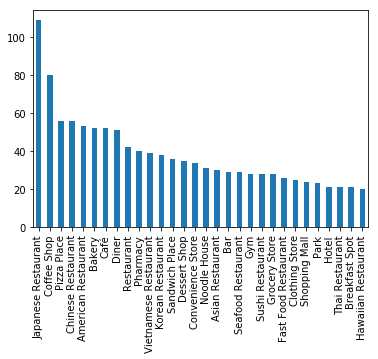

In [80]:
all_venues=oahu_venues['Venue Category'].value_counts()#.plot(kind='bar')
top30=all_venues.head(30)
top30.plot(kind='bar')

## K-Means Clustering w/ high school scores and crime
### Normalize the high school scores and crime columns

In [81]:
from sklearn.preprocessing import StandardScaler

df_scaled= df_combined.copy()
col_names=['Sum Proficiency','Total Crimes']
features = df_scaled[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df_scaled[col_names] = features
df_scaled.head()


,Zip,District,Sum Proficiency,School,Total Crimes,Neighborhood,Latitude,Longitude
0,96701,3,0.068594,Aiea High,0.245348,Aiea,21.3908,-157.9332
1,96706,8,0.351234,Campbell High,0.407478,Ewa Beach,21.3274,-158.0103
2,96707,8,-1.124775,Kapolei High,0.407478,Kapolei,21.3453,-158.0870
3,96731,4,-0.528091,Kahuku H&I,-0.918214,Kahuku,21.6750,-157.9725
4,96734,4,0.304127,"Kailua High,Kalaheo High",-0.918214,Kailua,21.4063,-157.7448


### Join Venue Data with normalized school/crime data

In [82]:
df_scaled_venues=df_scaled.join(oahu_grouped.set_index('Zip Code'),on='Zip')
df_scaled_venues.head()

,Zip,District,Sum Proficiency,School,Total Crimes,Neighborhood,Latitude,Longitude,ATM,Accessories Store,...,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfall,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,96701,3,0.068594,Aiea High,0.245348,Aiea,21.3908,-157.9332,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,96706,8,0.351234,Campbell High,0.407478,Ewa Beach,21.3274,-158.0103,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96707,8,-1.124775,Kapolei High,0.407478,Kapolei,21.3453,-158.0870,0.0,0.0,...,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,96731,4,-0.528091,Kahuku H&I,-0.918214,Kahuku,21.6750,-157.9725,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,96734,4,0.304127,"Kailua High,Kalaheo High",-0.918214,Kailua,21.4063,-157.7448,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Re-do Clustering

In [83]:
# set number of clusters
kclusters = 5
oahu_grouped_clustering2 = df_scaled_venues.drop(['Zip','District','School','Neighborhood','Latitude','Longitude'], 1)
# run k-means clustering
kmeans2 = KMeans(n_clusters=kclusters, random_state=0).fit(oahu_grouped_clustering2)
#Join sorted venues dataframe with the reduced dataframe of public high schools:
zipcode_venues_sorted2=df_scaled.join(zipcode_venues_sorted.set_index('Zip Code'),on='Zip').drop('Cluster Labels',1)
#Then insert clustering labels
zipcode_venues_sorted2.insert(0,'Cluster Labels',kmeans2.labels_)
zipcode_venues_sorted2.head()

,Cluster Labels,Zip,District,Sum Proficiency,School,Total Crimes,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,96701,3,0.068594,Aiea High,0.245348,Aiea,21.3908,-157.9332,Mobile Phone Shop,Golf Course,Park,Massage Studio,Jewelry Store,Japanese Restaurant,Golf Driving Range,Bank,Department Store,Pharmacy
1,1,96706,8,0.351234,Campbell High,0.407478,Ewa Beach,21.3274,-158.0103,Grocery Store,Golf Course,Park,Dry Cleaner,Restaurant,Yoga Studio,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store
2,2,96707,8,-1.124775,Kapolei High,0.407478,Kapolei,21.3453,-158.0870,Supermarket,Video Store,Coffee Shop,Construction & Landscaping,Hawaiian Restaurant,Hardware Store,Fishing Spot,Fish Market,Financial or Legal Service,Filipino Restaurant
3,4,96731,4,-0.528091,Kahuku H&I,-0.918214,Kahuku,21.6750,-157.9725,Trail,Airport,Yoga Studio,Farmers Market,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Event Service,Fast Food Restaurant
4,4,96734,4,0.304127,"Kailua High,Kalaheo High",-0.918214,Kailua,21.4063,-157.7448,Beach,Food Truck,Tennis Court,Other Repair Shop,Dumpling Restaurant,Electronics Store,Event Service,Farmers Market,Fast Food Restaurant,Yoga Studio


In [84]:
#Visualize Results
# create map
map_clusters = folium.Map(location=[honolulu_latitude, honolulu_longitude], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(zipcode_venues_sorted2['Latitude'], zipcode_venues_sorted2['Longitude'], 
                                  zipcode_venues_sorted2['Neighborhood'], zipcode_venues_sorted2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analyze Clusters

In [85]:
#Cluster Label 0
zipcode_venues_sorted2.loc[zipcode_venues_sorted2['Cluster Labels'] == 0, zipcode_venues_sorted2.columns[[1] + [3] + [4] + [5] + list(range(9, zipcode_venues_sorted2.shape[1]))]]

,Zip,Sum Proficiency,School,Total Crimes,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,96814,-0.057024,McKinley High,2.114746,Japanese Restaurant,Korean Restaurant,Café,Breakfast Spot,Grocery Store,Dessert Shop,Vietnamese Restaurant,Seafood Restaurant,Diner,Bar
17,96822,0.947918,Roosevelt High,2.114746,Scenic Lookout,Trail,State / Provincial Park,Electronics Store,Nature Preserve,Forest,Bus Station,Café,Art Gallery,Dumpling Restaurant


In [86]:
#Cluster Label 1
zipcode_venues_sorted2.loc[zipcode_venues_sorted2['Cluster Labels'] == 1, zipcode_venues_sorted2.columns[[1] + [3] + [4] + [5] + list(range(9, zipcode_venues_sorted2.shape[1]))]]

,Zip,Sum Proficiency,School,Total Crimes,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,96701,0.068594,Aiea High,0.245348,Mobile Phone Shop,Golf Course,Park,Massage Studio,Jewelry Store,Japanese Restaurant,Golf Driving Range,Bank,Department Store,Pharmacy
1,96706,0.351234,Campbell High,0.407478,Grocery Store,Golf Course,Park,Dry Cleaner,Restaurant,Yoga Studio,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store
6,96782,0.885109,Pearl City High,0.245348,Home Service,Convenience Store,Pharmacy,Park,Bus Stop,Pool,Harbor / Marina,Fish Market,Filipino Restaurant,Fast Food Restaurant
11,96797,0.068594,Waipahu High,0.245348,Clothing Store,Shoe Store,Accessories Store,Boutique,Kids Store,Chinese Restaurant,Tex-Mex Restaurant,Japanese Restaurant,Juice Bar,Chocolate Shop
15,96818,0.712385,"Moanalua High,Radford High",0.566331,Boat or Ferry,Soccer Field,Gift Shop,Sandwich Place,Snack Place,Bagel Shop,Food Truck,Shipping Store,Food Court,Monument / Landmark


In [87]:
#Cluster Label 2
zipcode_venues_sorted2.loc[zipcode_venues_sorted2['Cluster Labels'] == 2, zipcode_venues_sorted2.columns[[1] + [3] + [4] + [5] + list(range(9, zipcode_venues_sorted2.shape[1]))]]

,Zip,Sum Proficiency,School,Total Crimes,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,96707,-1.124775,Kapolei High,0.407478,Supermarket,Video Store,Coffee Shop,Construction & Landscaping,Hawaiian Restaurant,Hardware Store,Fishing Spot,Fish Market,Financial or Legal Service,Filipino Restaurant
10,96792,-2.459464,"Nanakuli H&I,Waianae High",0.407478,Pizza Place,Home Service,Juice Bar,Pharmacy,Hawaiian Restaurant,Dessert Shop,Diner,Restaurant,Optical Shop,Coffee Shop
13,96816,-1.658650,Kaimuki High,-0.086279,Coffee Shop,Sandwich Place,Japanese Restaurant,Pizza Place,Diner,Bookstore,Chinese Restaurant,Restaurant,Convenience Store,Cosmetics Shop
14,96817,-0.904944,Farrington High,0.566331,Pharmacy,Diner,Fast Food Restaurant,Chinese Restaurant,Noodle House,Juice Bar,Video Store,Asian Restaurant,Pizza Place,Liquor Store


In [88]:
#Cluster Label 3
zipcode_venues_sorted2.loc[zipcode_venues_sorted2['Cluster Labels'] == 3, zipcode_venues_sorted2.columns[[1] + [3] + [4] + [5] + list(range(9, zipcode_venues_sorted2.shape[1]))]]

,Zip,Sum Proficiency,School,Total Crimes,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,96789,1.387581,Mililani High,-1.435717,Hawaiian Restaurant,Park,Baseball Field,Dessert Shop,Mobile Phone Shop,Shopping Mall,Chinese Restaurant,Sandwich Place,Bar,Clothing Store
16,96821,1.356176,Kalani High,-0.086279,Food,Trail,Ice Cream Shop,Park,Yoga Studio,Electronics Store,Donut Shop,Dry Cleaner,Dumpling Restaurant,Event Service
18,96825,1.230558,Kaiser High,-0.086279,Home Service,Construction & Landscaping,Food,Trail,Harbor / Marina,Event Service,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store


In [89]:
#Cluster Label 4
zipcode_venues_sorted2.loc[zipcode_venues_sorted2['Cluster Labels'] == 4, zipcode_venues_sorted2.columns[[1] + [3] + [4] + [5] + list(range(9, zipcode_venues_sorted2.shape[1]))]]

,Zip,Sum Proficiency,School,Total Crimes,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,96731,-0.528091,Kahuku H&I,-0.918214,Trail,Airport,Yoga Studio,Farmers Market,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Event Service,Fast Food Restaurant
4,96734,0.304127,"Kailua High,Kalaheo High",-0.918214,Beach,Food Truck,Tennis Court,Other Repair Shop,Dumpling Restaurant,Electronics Store,Event Service,Farmers Market,Fast Food Restaurant,Yoga Studio
5,96744,-0.057024,Castle High,-0.918214,Japanese Restaurant,Clothing Store,Diner,Sandwich Place,Café,Coffee Shop,Asian Restaurant,Mobile Phone Shop,Pizza Place,BBQ Joint
7,96786,-0.276855,Leilehua High,-1.435717,Pizza Place,Bar,Historic Site,Café,Sporting Goods Shop,Yoga Studio,Farmers Market,Dumpling Restaurant,Electronics Store,Event Service
9,96791,-0.245451,Waialua H&I,-1.435717,Home Service,Gift Shop,Park,Coffee Shop,Clothing Store,Café,Farmers Market,Surf Spot,Board Shop,Beach


### Correlation between High School Scores & Crime? Pearson's R

In [90]:
import scipy.stats
r = scipy.stats.pearsonr(df_scaled['Sum Proficiency'],df_scaled['Total Crimes'])
print('The Pearson R coefficienct of', r[0], 'with a p-value of', r[1], 'indicates there was no significant correlation')

The Pearson R coefficienct of -0.018734352204653394 with a p-value of 0.9393208883962064 indicates there was no significant correlation


What if we tried to account for population and wealth? First, let's upload data and find the crimes per population

In [91]:

body = client_d2cf653ced7f4ce7bdabe9c0e97f1701.get_object(Bucket='datascienceproject-donotdelete-pr-8nunocffzcnlco',Key='population_wealth.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_popandwealth = pd.read_csv(body)


In [92]:

df_combinedpw=df_combined.join(df_popandwealth.set_index('Zip Code'), on='Zip')
df_combinedpw['Crimes Per Pop']=df_combinedpw['Total Crimes']/df_combinedpw['Population']
df_combinedpw.head()

,Zip,District,Sum Proficiency,School,Total Crimes,Neighborhood,Latitude,Longitude,City,Population,Wealth Index,Crimes Per Pop
0,96701,3,133.0,Aiea High,4525,Aiea,21.3908,-157.9332,Aiea,42573,164,0.106288
1,96706,8,142.0,Campbell High,4723,Ewa Beach,21.3274,-158.0103,Ewa Beach,71843,129,0.065741
2,96707,8,95.0,Kapolei High,4723,Kapolei,21.3453,-158.0870,Kapolei,44428,128,0.106307
3,96731,4,114.0,Kahuku H&I,3104,Kahuku,21.6750,-157.9725,Kahuku,3386,101,0.916716
4,96734,4,140.5,"Kailua High,Kalaheo High",3104,Kailua,21.4063,-157.7448,Kailua,47126,211,0.065866


Normalize once more

In [93]:
df_scaled2= df_combinedpw.copy()
col_names2=['Sum Proficiency','Crimes Per Pop','Wealth Index']
features2 = df_scaled2[col_names2]
scaler = StandardScaler().fit(features2.values)
features2 = scaler.transform(features2.values)
df_scaled2[col_names2] = features2
df_scaled2.head()

,Zip,District,Sum Proficiency,School,Total Crimes,Neighborhood,Latitude,Longitude,City,Population,Wealth Index,Crimes Per Pop
0,96701,3,0.068594,Aiea High,4525,Aiea,21.3908,-157.9332,Aiea,42573,0.364207,-0.286128
1,96706,8,0.351234,Campbell High,4723,Ewa Beach,21.3274,-158.0103,Ewa Beach,71843,-0.226519,-0.495766
2,96707,8,-1.124775,Kapolei High,4723,Kapolei,21.3453,-158.0870,Kapolei,44428,-0.243397,-0.286031
3,96731,4,-0.528091,Kahuku H&I,3104,Kahuku,21.6750,-157.9725,Kahuku,3386,-0.699100,3.903923
4,96734,4,0.304127,"Kailua High,Kalaheo High",3104,Kailua,21.4063,-157.7448,Kailua,47126,1.157468,-0.495117


### Multiple Linear Regression

In [94]:

from sklearn import linear_model
X = df_combinedpw[['Wealth Index','Crimes Per Pop']]
Y = df_combinedpw['Sum Proficiency']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)
print('Model Score: \n',regr.score(X,Y))
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Model Score: 
 0.24408954913649572
Intercept: 
 93.03520808802969
Coefficients: 
 [ 0.26545598 -0.16048257]


In [95]:
r = scipy.stats.pearsonr(df_combinedpw['Sum Proficiency'],df_combinedpw['Wealth Index'])
print('The Pearson R coefficienct of', r[0], 'with a p-value of', r[1], 'indicates there is significant positive correlation')

The Pearson R coefficienct of 0.49405325030096303 with a p-value of 0.03155371803786947 indicates there is significant positive correlation


## K Means Clustering with only Crime & Wealth Index

In [96]:
# set number of clusters
kclusters = 5
oahu_grouped_clustering3 = df_scaled2[['Wealth Index','Crimes Per Pop']]
# run k-means clustering
kmeans3 = KMeans(n_clusters=kclusters, random_state=0).fit(oahu_grouped_clustering3)
#Then insert clustering labels
df_scaled2.insert(0,'Cluster Labels',kmeans3.labels_)

In [97]:
#Visualize Results
# create map
map_clusters = folium.Map(location=[honolulu_latitude, honolulu_longitude], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_scaled2['Latitude'], df_scaled2['Longitude'], 
                                  df_scaled2['Neighborhood'], df_scaled2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [98]:
#Cluster Label 0
df_scaled2.loc[df_scaled2['Cluster Labels'] == 0, df_scaled2.columns[[1] + [6] + [11] + [12] ]]

,Zip,Neighborhood,Wealth Index,Crimes Per Pop
7,96786,Wahiawa,-1.272949,-0.545588
9,96791,Waialua,-0.884757,0.637450
10,96792,Waianae,-1.070414,-0.363148
12,96814,Honolulu,-0.834123,0.808367
14,96817,Kapalama,-0.580955,-0.363343
15,96818,Pearl Harbor,-0.901635,-0.344955


In [99]:
#Cluster Label 1
df_scaled2.loc[df_scaled2['Cluster Labels'] == 1, df_scaled2.columns[[1] + [6] +  [11] + [12] ]]

,Zip,Neighborhood,Wealth Index,Crimes Per Pop
3,96731,Kahuku,-0.6991,3.903923


In [100]:
#Cluster Label 2
df_scaled2.loc[df_scaled2['Cluster Labels'] == 2, df_scaled2.columns[[1] + [6] + [11] + [12] ]]

,Zip,Neighborhood,Wealth Index,Crimes Per Pop
16,96821,Waialae / Kahala,2.895892,0.395124


In [101]:
#Cluster Label 3
df_scaled2.loc[df_scaled2['Cluster Labels'] == 3, df_scaled2.columns[[1] + [6] + [11] + [12] ]]

,Zip,Neighborhood,Wealth Index,Crimes Per Pop
4,96734,Kailua,1.157468,-0.495117
18,96825,Honolulu,1.613172,-0.156259


In [102]:
#Cluster Label 4
df_scaled2.loc[df_scaled2['Cluster Labels'] == 4, df_scaled2.columns[[1] + [6] + [11] + [12] ]]

,Zip,Neighborhood,Wealth Index,Crimes Per Pop
0,96701,Aiea,0.364207,-0.286128
1,96706,Ewa Beach,-0.226519,-0.495766
2,96707,Kapolei,-0.243397,-0.286031
5,96744,Kaneohe,0.499230,-0.545767
6,96782,Pearl City,0.111039,-0.245409
8,96789,Mililani,0.161672,-0.602988
11,96797,Waipahu,-0.209641,-0.517369
13,96816,Waialae / Kahala,0.381085,-0.436945
17,96822,Makiki,-0.260275,-0.060050
